# Exercise 04
## Supervised Segmentations

In this exercise, we will explore supervised segmentation for assigning semantic labels to individual pixels in the image. Knowledge about the semantics of the image is essential for image and video understanding and is crucial for technologies like autonomous driving.

## Imports

This will setup your whole environment such that you can work with the rest of the notebook.

### General Imports

In [1]:
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

## Set up directory paths and (optionally) mount in Google Colab
If you work with google colab set the `USING_COLAB` variable to `True` and following cell to mount your gdrive.

In [2]:
USING_COLAB = True
USE_CPU = False
# Use the following lines if you want to use Google Colab
# We presume you created a folder "cv3dst" within your main drive folder, and put the exercise there.
# NOTE: terminate all other colab sessions that use GPU!
# NOTE 2: Make sure the correct exercise folder (e.g exercise_03) is given.

if USING_COLAB:
    from google.colab import drive
    import os

    gdrive_path='/content/gdrive/MyDrive/masters/CVIII/task4/exercise_04'

    # This will mount your google drive under 'MyDrive'
    drive.mount('/content/gdrive', force_remount=True)
    # In order to access the files in this notebook we have to navigate to the correct folder
    os.chdir(gdrive_path)
    # Check manually if all files are present
    print(sorted(os.listdir()))
    root_dir = Path(gdrive_path).parent
else:
    # root_dir = Path('./cv3dst/')
    root_dir = Path('/storage/remote/adm9/cv3dst/cv3ws23/cv3_exercises/cv3dst')
dataset_dir = root_dir.joinpath("datasets")
output_dir = root_dir.joinpath('exercise_04', 'models')
output_dir.mkdir(parents=True, exist_ok=True)

device = torch.device('cuda') if torch.cuda.is_available() and not USE_CPU else torch.device('cpu')

Mounted at /content/gdrive
['exercise_code', 'models', 'supervised_segmentation.ipynb']


### Exercise Specific Imports

In [3]:
from exercise_code.data.obj_segmentation import (
    LinearProbingNet,
    PACNet,
    training,
    visualize_model
)
from exercise_code import visualize_davis, load_davis_dataset, create_embeddings, downsample_annotations
from exercise_code.test import (
    test_linear_probing,
    test_pix_adaptive_conv_nets,
)

%load_ext autoreload
%autoreload 2

## Extract Embeddings from Images

The following lines of code will extract per-patch feature embeddings from the images of the Davis dataset. As this process will take a while, we recommend you carefully read through and familiarize yourself with the rest of this notebook.

<div class="alert alert-info">
    <h3>Task: Create Embeddings for the Images</h3>
    <p> You only need to do this once. If you have successfully run the code below, set the <code>INITIAL_RUN</code> to <code>False</code> to skip this in the subsequent runs of the code for a speedup. After running the cell below, you should see image embeddings for the Davis dataset under <code>datasets/obj_seg/train/embeddings</code> and <code>datasets/obj_seg/test/embeddings</code>, respectively.</p>
</div>

In [4]:
INITIAL_RUN = False
PATCH_SIZE = 16

if INITIAL_RUN:
    dino = torch.hub.load("facebookresearch/dino:main", f"dino_vits{PATCH_SIZE}")

    dino = dino.to(device)
    dino.eval()

    print("Creating embddings for the training set")
    create_embeddings(dataset_dir.joinpath("obj_seg", "train"), dino, device)
    print("Downsampling annotations for the training set")
    downsample_annotations(dataset_dir.joinpath("obj_seg", "train"), PATCH_SIZE)
    print("Creating embddings for the test set")
    create_embeddings(dataset_dir.joinpath("obj_seg", "test"), dino, device)
    print("Downsampling annotations for the test set")
    downsample_annotations(dataset_dir.joinpath("obj_seg", "test"), PATCH_SIZE)

# Some information about DINO ...

DINO is short for self-**di**stillation with **no** labels. It was introduced at ICCV in 2021 [1]. It uses the paradigm of self-supervised learning to train with random, unlabeled examples. Thus, it can use large amounts of data compared to supervised methods that require annotations. The recent advances in vision transformers (ViTs) allow DINO to produce robust and reliable image representations in latent space/embeddings. These embeddings can be used for unsupervised tasks (see exercise 05) or leveraged for supervised tasks. As we will see, the pre-trained embeddings allow these supervised tasks to use only a fraction of the previously needed annotated data. Therefore, we can learn a meaningful segmentation net even with our limited computing power in this course.

The following gives a quick rundown of the training scheme of the original DINO.

## Knowledge Distillation
Knowledge distillation aims for a student network $F_s(x)$ to reproduce the output of an already trained teacher network $F_t(x)$. The original intention was to take a large teacher network and a small student network to reduce computational demand at inference time [4]. The training supervision was done on the logit outputs of the teacher model to distil as much information as possible.

## Self-Distillation
Self-distillation adopts this scheme so that the student and teacher networks share the same architecture. DINO trains them simultaneously, employing the exponential moving average (EMA) to calculate the teacher weights $\theta_t$ from the past student weights $\theta_s$.
$$\theta_t \gets \lambda \theta_t - (1 - \lambda)\theta_s$$
In the training scheme of DINO, two crops of the same image $x$ are given to the student and teacher networks. A cross-entropy loss then compares the output distributions of both networks for the different crops. The output is an additional output token, the so-called [CLS] token added to the patch tokens, encoding the whole image.

## Vision Transformer
The ViT of DINO divides an image into patches of $16 \times 16$ pixels (versions with $8 \times 8$ pixels are also available) and encodes them with a linear layer to an embedding space. These patch tokens are concatenated with an initial [CLS] token and fed through transformer layers to produce a final set of embeddings (for each patch + cls). Those embeddings encode semantic information, and recent papers have used those for downstream tasks.

For more information, we recommend checking out the paper [1] and the follow-up work of DINOv2 [2], which provides even better embeddings.
If you want to gain insight into what the cls-token and patch-tokens are encoding, you can also have a look at [6], where unprocessed plain DINO features are solving for the texture transfer task.
Another work [7] shows results on unsupervised clustering in the DINO feature space.
The related work of [3] also provides an exciting insight into vision transformers [3].

[1] Caron et al. Emerging Properties in Self-Supervised Vision Transformers, ICCV 2021
[2] Oquab et al. DINOv2: Learning Robust Visual Features without Supervision, arXiv 2023
[3] Darcet et al. Vision Transformers Need Registers, arXiv 2023
[4] Hinton et al. Distilling the Knowledge in a Neural Network, arXiv 2015
[5] Dosovitskiy et al. An image is worth 16x16 words: Transformers for image recognition at scale, ICLR 2021
[6] Tumanyan et al. Splicing ViT Features for Semantic Appearance Transfer
[7] Amir et al. Deep ViT Features as Dense Visual Descriptors

## Load Object Segmentation Datasets

In this exercise, we will be working with a subset of the [DAVIS 2016](https://davischallenge.org/davis2016/browse.html) [1] dataset. DAVIS provides densely annotated video segmentation data. We use the 2016 DAVIS version with single instance annotation per video sequence.

[1] Perazzi et al. A Benchmark Dataset and Evaluation Methodology for Video Object Segmentation, CVPR 2016

In [8]:
train_dataset, test_dataset = load_davis_dataset(dataset_dir.joinpath("obj_seg"), PATCH_SIZE)

## Visualize Dataset

In the following we provide a visualization of the dataset. To better understand the problem we visualize
* the input images
* the input image with overlaid annotations
* the input image overlaid with annotations downsampled to the patch size
* the embeddings per patch with the first 3 components of PCA mapped to RGB colors
  
You can visualize different examples by changing the index provided as the second argument.

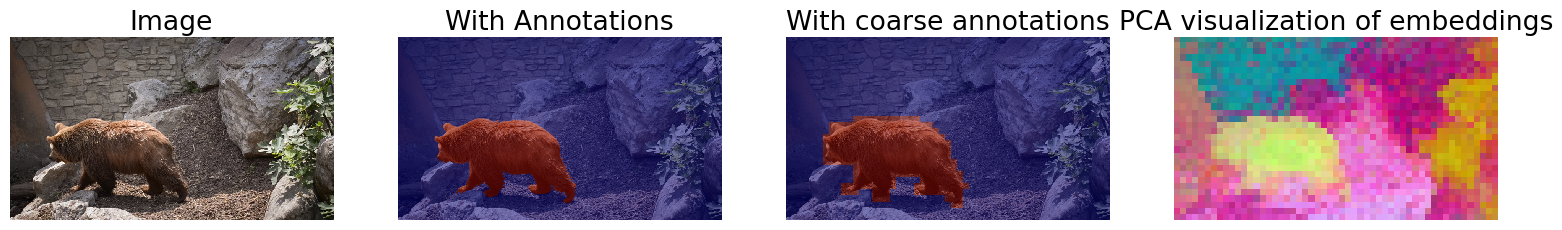

In [9]:
visualize_davis(train_dataset, 0)

## Exercise Part I - Linear Probing

In this exercise we will be using the simplest of network architectures to classify each patch as either foreground or background based on their DINO embeddings. This allows us to easily get a patch based image segmentation.

Your task is to complete the simple network architecture that gets an patch embedding and outputs a binary classification score between $0$ and $1$.

<div class="alert alert-info">
    <h3>Task: Linear Probing</h3>
    <p> Go to <code>exercise_code/data/obj_segmentation/linear_probing.py</code> and the <code>LinearProbingNet</code> class. You need to implement a <b>one</b> layer network with a sigmoid layer by completing the <code>__init__</code> and <code>forward</code> methods of the network.</p>
</div>

<div class="alert alert-danger">
    <h3>Test: Linear Probing</h3>
    <p> Run the following cell to execute the test case for the linear probing.</p>
</div>

In [5]:
_ = test_linear_probing()

Congratulations: The output shape of the network is correct
Congratulations: The output returned gives a probability between 0 and 1
Class LinearProbingNet correctly implemented. Tests passed: 2/2
Score: 100/100


If the previous test ran successfully you can now train a linear probing network on pretrained DiNO patch embeddings to produce coarse object segmentation masks. The input dimension is set to 384 as this is the dimensionality of the DINO embeddings.

In [10]:
linear_probing = LinearProbingNet(384)

batch_size = 16
dataloaders = {
    "train": DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True),
    # "test": DataLoader(test_dataset, batch_size=batch_size, drop_last=False),
    "test": DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False),
}

loss_fn = nn.BCELoss()
optimizer = optim.Adam(linear_probing.parameters(), lr=5.0e-4)

training(linear_probing, dataloaders, loss_fn, optimizer, 10, device)
torch.save(linear_probing.state_dict(), output_dir.joinpath("linear_net.pt"))

   Epoch      Split   Loss   Acc  Prcn  Rcll   IOU
       1      train   1.04     -     -     -     -
       2      train   0.57     -     -     -     -
       3      train   0.34     -     -     -     -
       4      train   0.23     -     -     -     -
       5      train   0.18     -     -     -     -
       5        val   0.17  0.94  0.92  0.85  0.80
       6      train   0.15     -     -     -     -
       7      train   0.14     -     -     -     -
       8      train   0.12     -     -     -     -
       9      train   0.11     -     -     -     -
      10      train   0.10     -     -     -     -

      10       bear   0.12  0.97  0.96  0.93  0.90
      10        dog   0.12  0.94  0.95  0.88  0.83
      10    overall   0.12  0.96  0.96  0.90  0.87
Against full resolution annotations

      10       bear   0.13  0.97  0.90  0.95  0.87
      10        dog   0.13  0.94  0.90  0.89  0.82
      10    overall   0.13  0.96  0.90  0.92  0.85


Results should be approximately. Metrics marked with <sup>*</sup> are calculated with regard to the non-downsampled ground truth.

<div>
    <table>
        <tr>
            <td>Class</td>
            <td>Acc</td>
            <td>Prcn</td>
            <td>Rcll</td>
            <td>IoU</td>
            <td></td>
            <td>Acc<sup>*</sup></td>
            <td>Prcn<sup>*</sup></td>
            <td>Rcll<sup>*</sup></td>
            <td>IoU<sup>*</sup></td>
        </tr>
        <tr>
            <td>Bear</td>
            <td>98%</td>
            <td>0.94</td>
            <td>0.96</td>
            <td>0.90</td>
            <td></td>
            <td>97%</td>
            <td>0.87</td>
            <td>0.96</td>
            <td>0.90</td>
        </tr>
        <tr>
            <td>Dog</td>
            <td>94%</td>
            <td>0.86</td>
            <td>0.96</td>
            <td>0.82</td>
            <td></td>
            <td>95%</td>
            <td>0.83</td>
            <td>0.89</td>
            <td>0.92</td>
        </tr>
        <tr>
            <td>Overall</td>
            <td>96%</td>
            <td>0.90</td>
            <td>0.96</td>
            <td>0.86</td>
            <td></td>
            <td>96%</td>
            <td>0.85</td>
            <td>0.92</td>
            <td>0.91</td>
        </tr>
    </table>
</div>

### Visualizing the results

To get a feel for the performance of your model, you can visualize the image segmentations and compare them to the ground truth. The index for the dataset is passed as the third argument.

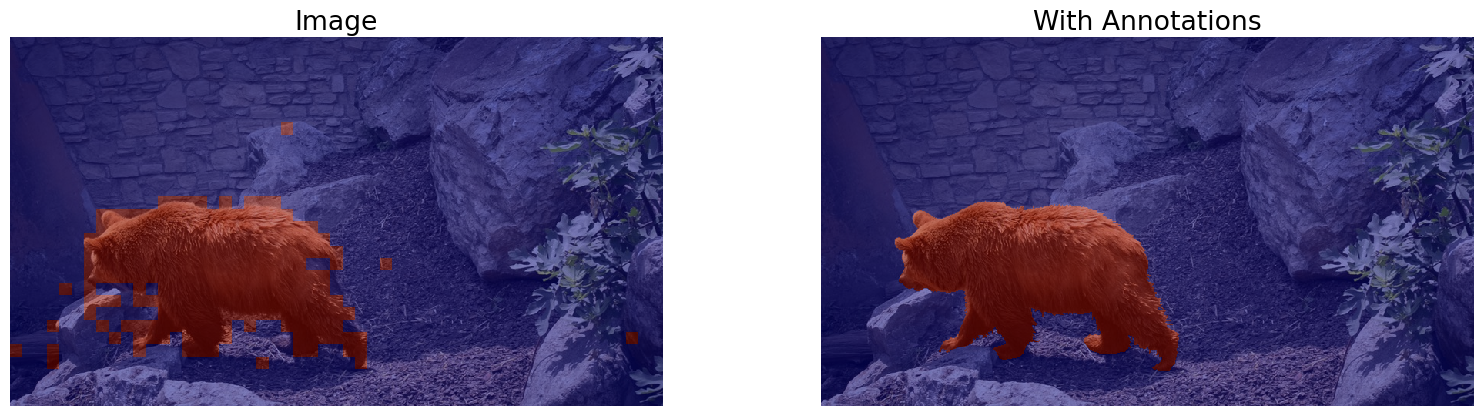

In [12]:
visualize_model(linear_probing, train_dataset, 0, device)

## Part II - Refining the Prediction with Pixel-Adaptive Convolutional Networks

Linear probing gives us already good results for object segmentation. As the DiNO features provide powerful high-level embeddings of the patches. As the patches have as size of $16 \times 16$ pixels the predictions are very coarse. Details of the object are not visible in the segmentation masks. We can also see this in the metrics calculated with the non-downsampled ground truth masks.

To address the coarse predictions of the masks, we need to upsample these results. In this exercise we look at pixel-adaptive convolutional (PAC) layers introduced in [1] to do the upsampling. Unlike traditional upconvolution layers, PAC layers don't have fixed convolutional filters but rather filters that are adapted with the image content to produce spatially variant filters that give the network more flexibility.

The spatially variant filters are produces by adapting the convolutional weights with a spacially varying kernel. The kernel weights are dependent on the local image features. See the exercise slides for an visual example.

### Kernel
In this exercise we use a gaussian kernel. Given an image patch the kernel weights for a pixel $i$ are calculated by
$$K(\boldsymbol{f}_i, \boldsymbol{f}_j) = \exp\left(-\frac{1}{2} (\boldsymbol{f}_i - \boldsymbol{f}_j)^\top (\boldsymbol{f}_i - \boldsymbol{f}_j) \right)\,,$$
where $j$ denotes the center pixel of the patch and $\boldsymbol{f}_i, \boldsymbol{f}_j$ are the respective feature vectors. In our case, the features are the pixels RGB values.

[1] [Su et al., Pixel-Adaptive Convolutional Networks Networks, CVPR 2019](https://arxiv.org/pdf/1904.05373.pdf)

<div class="alert alert-info">
    <h3>Task: Pixel-Adaptive Convolutional Networks</h3>
    <p> Go to <code>exercise_code/data/obj_segmentation/pixel_adaptive_conv_networks.py</code>. You need to complete the methods <code>packernel2d</code> for computing the kernel weights and <code>pacconv2d</code> for doing the pixel-adaptive convolution. Please refer to the exercise slides for visual examples on how to implement both functions.</p>
</div>

<div class="alert alert-danger">
    <h3>Test: Pixel-Adaptive Convolutional Networks</h3>
    <p> Run the following cell to execute the test case for the pac layers.</p>
</div>

In [ ]:

# def pacconv2d(input, kernel, weight, bias=None, stride=1, padding=0, dilation=1):
#     # TODO: check shape. Give the shape of the input, kernel, weight, bias
#     kernel_size = tuple(weight.shape[-2:])
#     stride = _pair(stride)
#     padding = _pair(padding)
#     dilation = _pair(dilation)

#     ########################################################################
#     # TODO:                                                                #
#     # Perform the pixel-adaptive convolution operation. For this you are   #
#     # given the input feature map, the previously computed pixel adaptive  #
#     # kernel and the weights of the convolution. An optional bias          #
#     # is also given. Use it if it is not None.                             #
#     # NOTE: Again, the nd2col can be used to unfold the input feature map. #
#     # NOTE: Check if the output has the correct shape.                     #
#     ########################################################################


#     pass

#     ########################################################################
#     #                           END OF YOUR CODE                           #
#     ########################################################################

#     return output


In [13]:
_ = test_pix_adaptive_conv_nets()

Congratulations: The kernel shape is correct.
Congratulations: The center kernel weight is correct.
Please rethink about the computation of the kernel.
Some tests failed for method packernel2d(). Tests passed: 2/3
Please rethink about the computation of the convolution.
Some tests of PixAdaptiveConvNetsTest failed. Tests passed: 2/4
Score: 50/100


If the previous test ran successfully you can now train a linear probing network on pretrained DiNO patch embeddings to produce coarse object segmentation masks.

In [ ]:
# linear_probing2 = LinearProbingNet(384)

# batch_size = 4
# dataloaders = {
#     "train": DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True),
#     "test": DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False),
# }

# loss_fn = nn.BCELoss()
# optimizer = optim.Adam(linear_probing2.parameters(), lr=5.0e-4)

# training(linear_probing2, dataloaders, loss_fn, optimizer, 5, device)
# torch.save(linear_probing2.state_dict(), output_dir.joinpath("pac_net.pt"))

In [14]:
pac_net = PACNet()
pac_net.to(device)

batch_size = 4
dataloaders = {
    "train": DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True),
    "test": DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False),
}

loss_fn = nn.BCELoss()
optimizer = optim.Adam(pac_net.parameters(), lr=5.0e-4)

training(pac_net, dataloaders, loss_fn, optimizer, 5, device)
torch.save(pac_net.state_dict(), output_dir.joinpath("pac_net.pt"))

   Epoch      Split   Loss   Acc  Prcn  Rcll   IOU
       1      train   0.42     -     -     -     -
       2      train   0.15     -     -     -     -
       3      train   0.12     -     -     -     -
       4      train   0.11     -     -     -     -
       5      train   0.11     -     -     -     -

       5       bear   0.15  0.97  0.96  0.91  0.88
       5        dog   0.15  0.94  0.96  0.83  0.79
       5    overall   0.15  0.96  0.96  0.86  0.83


Results should be approximately.
<div>
    <table>
        <tr>
            <td>Class</td>
            <td>Acc</td>
            <td>Prcn</td>
            <td>Rcll</td>
            <td>IoU</td>
        </tr>
        <tr>
            <td>Bear</td>
            <td>99%</td>
            <td>0.97</td>
            <td>0.97</td>
            <td>0.94</td>
        </tr>
        <tr>
            <td>Dog</td>
            <td>98%</td>
            <td>0.98</td>
            <td>0.95</td>
            <td>0.94</td>
        </tr>
        <tr>
            <td>Overall</td>
            <td>99%</td>
            <td>0.98</td>
            <td>0.96</td>
            <td>0.94</td>
        </tr>
    </table>
</div>

### Visualization

Again, you can visualize the performance of your network and compare it to the ground truth. This time you will see that the predictions are on a per-pixel instead of a per-patch level.

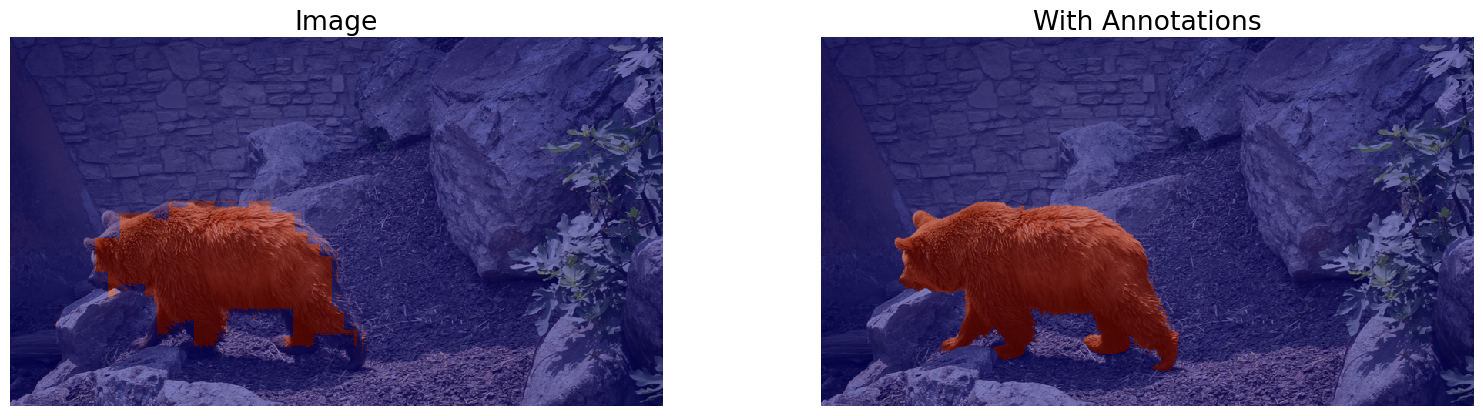

In [15]:
visualize_model(pac_net, train_dataset, 0, device)
# visualize_model(linear_probing2, train_dataset, 0, device)

# Exercise submission

In [16]:
from exercise_code.submit import submit_exercise

submit_exercise('../output/exercise04')

relevant folders: ['models', 'exercise_code']
notebooks files: ['supervised_segmentation.ipynb']
Adding folder models
Adding folder exercise_code
Adding notebook supervised_segmentation.ipynb
Zipping successful! Zip is stored under: /content/gdrive/MyDrive/masters/CVIII/task4/output/exercise04.zip
